In [2]:
import numpy as np
from sklearn.datasets import make_blobs

In [ ]:
X, y = make_blobs(
    n_samples = 500,
    n_features = 2,
    random_state = 42,
    centers=[(0, 0)],
    cluster_std=1.0
)

def project_vector_gen():
    v = np.random.multivariate_normal(mean=(0, 0), cov=np.identity(2))
    v = v / np.linalg.norm(v)
    return v

n_projections = 5
projections = [project_vector_gen() for _ in range(n_projections)]
print(projections)

[array([-0.99995973,  0.00897404]), array([-0.20656813, -0.97843222]), array([0.13390733, 0.99099386]), array([-0.99142545, -0.13067355]), array([-0.60771265,  0.794157  ])]


In [5]:
bins = 30
histograms = []

for v in projections:
    projection_values = X.dot(v)
    scalar_min, scalar_max = projection_values.min(), projection_values.max()
    margin = max(1.0, (scalar_max - scalar_min) * 0.5)
    rng = (scalar_min - margin, scalar_max + margin)
    counts, edges = np.histogram(projection_values, bins=bins, range = rng)
    probs = counts.astype(float) / counts.sum()
    histograms.append((edges, probs))

In [6]:
def score_points(X_points, projections, histograms):
    scores = np.zeros(len(X_points), dtype=float)
    for i, x in enumerate(X_points):
        p_vals = []
        for v, (edges, probs) in zip(projections, histograms):
            pv = x.dot(v)
            idx = np.digitize(pv, edges) - 1
            idx = np.clip(idx, 0, len(probs) - 1)
            p_vals.append(probs[idx])
        scores[i] = np.mean(p_vals)
    return scores

# 3) testing: uniform data between -3 and 3
X_test = np.random.uniform(-3, 3, size=(500, 2))
test_scores = score_points(X_test, projections, histograms)

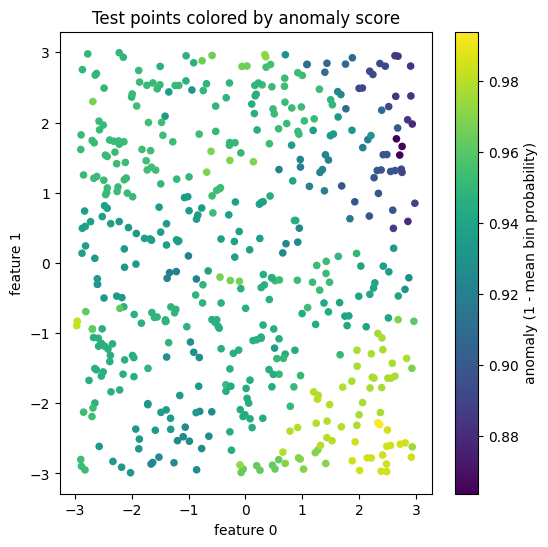

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sc = plt.scatter(X_test[:, 0], X_test[:, 1], c=1 - test_scores, cmap='viridis', s=20)
plt.colorbar(sc, label='anomaly (1 - mean bin probability)')
plt.title('Test points colored by anomaly score')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()